In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [3]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [4]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [165]:
def smdev(ys,win=3,poly=2):
    smoothed = signal.savgol_filter(ys,window_length=win,polyorder=poly)
    reldif = ((ys-smoothed)/ys)
    rmse = np.sqrt(np.mean(reldif**2))
    return rmse, reldif



def find_best_root(data,max_lig_index,target_index):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    """
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        try:
            sp.stats.mode(temp)[0][0] > 0
            holder.append(sp.stats.mode(temp)[0][0])
        except: print('negative root encountered')
            
    result = np.array(holder)
    
    if smdev(result)[0] > 1. :
        print('Large Deviation')
        return result ,smdev(np.array(holder))[1]
        
    else:
        return result

In [7]:
def k1solv(var,parm,rtot,ltot):
    
    k1 = parm
    
    (L,R,RL) = var
    
    eq1 = R + RL - rtot
    eq2 = L + RL - ltot
    eq3 = k1 * R * L - RL
    
    return np.array([eq1,eq2,eq3])

In [11]:
lig_concs = dilser()

In [12]:
guesses = [guessgen(3) for i in range(100)]

In [17]:
res = np.array([[sp.optimize.root(k1solv,i,args=(2.0,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in guesses])

In [18]:
L = find_best_root(res,18,0)
R = find_best_root(res,18,1)
RL = find_best_root(res,18,2)

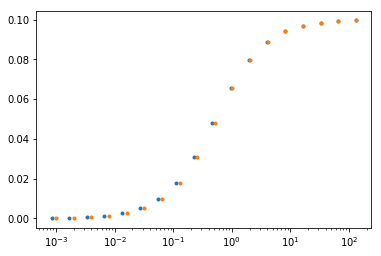

In [19]:
plt.semilogx(L,RL,'.')
plt.semilogx(lig_concs,RL,'.')

In [21]:
def k2solv(var,parm,rtot,ltot):
    
    k1 = parm[0]
    k2 = parm[1]
    
    (L,R,RL,RLL) = var
    
    eq1 = (R + RL + RLL) - rtot
    eq2 = (L + RL + 2*RLL) - ltot
    eq3 = (k1*R*L) - RL
    eq4 = (k2*k1*R*L*L) - RLL
    
    return np.array([eq1,eq2,eq3,eq4])

In [22]:
parmk2 = np.array([4.,1.])

In [24]:
k2guesses = [guessgen(4) for i in range(100)]
resk2 = np.array([[optimize.root(k2solv,i,args=(parmk2,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in k2guesses])

In [26]:
dL = find_best_root(resk2,18,0)
dR = find_best_root(resk2,18,1)
dRL = find_best_root(resk2,18,2)
dRLL = find_best_root(resk2,18,3)

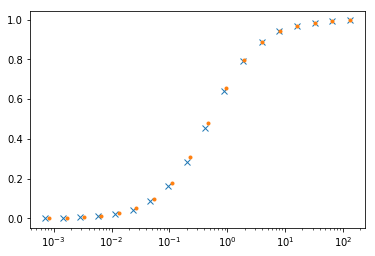

In [27]:
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')
plt.semilogx(L,RL/0.1,'.')

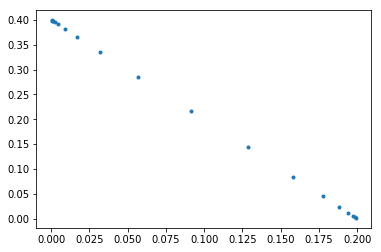

In [28]:
plt.plot((dRL + 2*dRLL),((dRL + 2*dRLL)/dL),'.')

In [29]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = (M + 2*MM + ML + 2*MML + 2*MMLL) - rtot
    eq2 = (L + ML + MML + 2*MMLL) - ltot
    eq3 = (l20 * M*M) - MM
    eq4 = (k11 * L * M) - ML
    eq5 = (l20 * k21 * M*M * L) - MML
    eq6 = (k22 * L * MML) - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [35]:
rtotwym = np.array([1e-4,1e-3,1e-2,1e-1,1e0])
parmwym = np.array([2.,4.,1.,500.])
wymguesses = [guessgen(6) for i in range(100)]

In [36]:
wymar = np.array([[[optimize.root(wymsol,i,args=(parmwym,q,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in wymguesses] for q in rtotwym])

In [109]:
wymL_0 = find_best_root(wymar[0],18,0)
wymM_0 = find_best_root(wymar[0],18,1)
wymMM_0 = find_best_root(wymar[0],18,2)
wymML_0 = find_best_root(wymar[0],18,3)
wymMML_0 = find_best_root(wymar[0],18,4)
wymMMLL_0 = find_best_root(wymar[0],18,5)

Large Deviation
Large Deviation


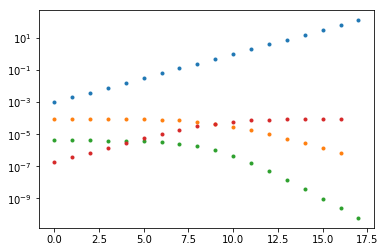

In [118]:
plt.semilogy(wymL_0,'.')
plt.semilogy(wymM_0,'.')
plt.semilogy(wymMM_0,'.') #this one
plt.semilogy(wymML_0,'.')
#plt.semilogy(wymMML_0,'.')
#plt.semilogy(wymMMLL_0,'.') #this one

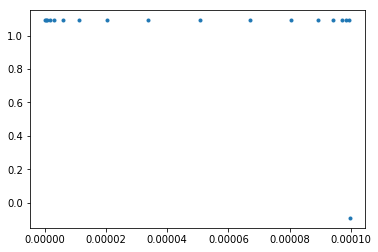

In [42]:
bound = wymML_0 + wymMML_0 + 2*wymMMLL_0

plt.plot(bound,(bound/wymML_0),'.')

In [63]:
smdev(wymMMLL_0) < 1.

False

In [108]:
np.abs(find_best_root(wymar[0],18,))

Large Deviation


array([[  1.67104499e-11,   6.65758683e-11,   2.64194977e-10,
          1.04020965e-09,   4.03286855e-09,   1.51760888e-08,
          5.40134379e-08,   1.74271808e-07,   4.81057460e-07,
          1.07392287e-06,   1.89429617e-06,   2.71075938e-06,
          3.33268604e-06,   3.72714663e-06,   3.95116932e-06,
          4.07083076e-06,   4.13271004e-06,   5.91284241e-04],
       [  1.03237949e+00,   1.03650323e+00,   3.91790772e-01,
          3.53967250e-01,   2.89258492e-01,   1.93066824e-01,
          8.15342631e-02,   2.73158630e-03,   2.81744218e-02,
          1.37955721e-02,   1.84575950e-03,   4.98638242e-03,
          2.31364595e-03,   2.08091080e-04,   4.22967929e-04,
          1.23618331e+01,   8.11782581e+00,   1.41846416e-02]])

ValueError: window_length must be odd.

In [121]:
def test_rootfinder(data,max_lig_index,target_index):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    """
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        roots,indices,counts = np.unique(temp,return_counts=True,return_index=True)
        posroots = roots[roots>0]
        posinds = indices[roots>0]
        poscounts = counts[roots>0]
        try:
            sp.stats.mode(temp)[0][0] > 0
            holder.append(sp.stats.mode(temp)[0][0])
        except: print('negative root encountered')
            
    result = np.array(holder)
            
    return result

In [122]:
test_rootfinder(wymar[0],18,5)

array([  1.67104499e-11,   6.65758683e-11,   2.64194977e-10,
         1.04020965e-09,   4.03286855e-09,   1.51760888e-08,
         5.40134379e-08,   1.74271808e-07,   4.81057460e-07,
         1.07392287e-06,   1.89429617e-06,   2.71075938e-06,
         3.33268604e-06,   3.72714663e-06,   3.95116932e-06,
         4.07083076e-06,   4.13271004e-06,   5.91284241e-04])

In [152]:
def colroots(data,max_lig_index,target_index): 
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[clctd[:,1].argsort()]
        holder.append(clctd[:,0])
    
    firstguess = [i[-1] for i in holder]
    
    return(firstguess)

In [281]:
restest = colroots(wymar[0],18,5)

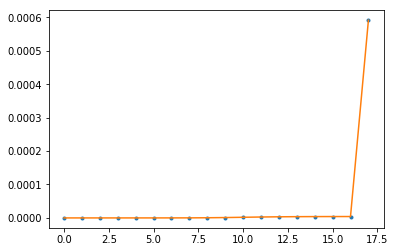

In [282]:
plt.plot(restest,'.')
plt.plot(signal.savgol_filter(restest,window_length=3,polyorder=2))

In [283]:
smdev(restest)

(3.785799838261667e-15,
 array([ -3.86724988e-16,  -3.88269726e-16,  -3.91368442e-16,
         -3.97602836e-16,  -4.10219476e-16,  -4.36044162e-16,
         -3.67544364e-16,  -3.03775807e-16,  -2.20096614e-16,
         -1.97181978e-16,  -2.23574581e-16,  -1.56235362e-16,
         -2.54159239e-16,  -2.27260430e-16,  -2.14375259e-16,
         -2.08073732e-16,  -1.59867422e-14,   9.16819778e-16]))

In [284]:
a = signal.savgol_filter(restest,window_length=3,polyorder=2)

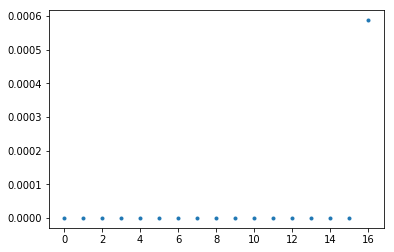

In [285]:
plt.plot(np.abs(a[1:] - a[:-1]),'.')

In [286]:
b = np.array(restest)

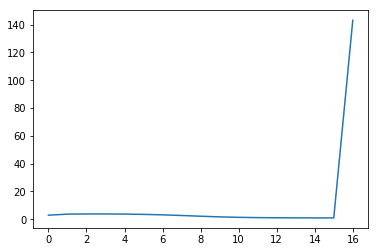

In [287]:
plt.plot((b[1:] - b[:1])/b[:-1])

In [288]:
import numpy as np

def outliers_modified_z_score(ys):
    threshold = 5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)

In [289]:
outliers_modified_z_score(((b[1:] - b[:1])/b[:-1]))

(array([16]),)

In [290]:
from scipy import interpolate

In [304]:
x = np.arange(len(restest))

In [307]:
f = interpolate.interp1d(x,restest,kind='cubic',fill_value='extrapolate')

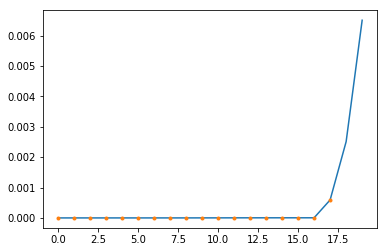

In [308]:
plt.plot(f(np.arange(20)))
plt.plot(restest,'.')